In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork

from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete.CPD import TabularCPD

# Structure Learning
from pgmpy.base import DAG
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore
import networkx as nx

from sklearn.metrics import classification_report, confusion_matrix

from pgmpy.inference import VariableElimination

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder

# Loading Data

In [2]:
df_train = pd.read_csv('./Data/cardiovascular_train.csv')
df_test = pd.read_csv('./Data/cardiovascular_test.csv')

### Applying SMOTE to Diabetes Column

In [3]:
categorical_columns = ['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',   # All Exept SocioeconomicStatus
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile']

encoders = {col: LabelEncoder() for col in categorical_columns}

In [4]:
# Apply label encoding to each column
for col in categorical_columns:
    df_train[col] = encoders[col].fit_transform(df_train[col])
    df_test[col] = encoders[col].transform(df_test[col])

X_train = df_train.drop('Diabetes', axis=1)
y_train = df_train['Diabetes']
X_test = df_test.drop('Diabetes', axis=1)
y_test = df_test['Diabetes']

In [5]:
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_columns if col != 'Diabetes']

smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42, sampling_strategy=0.2)

X_train_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)
y_resampled.value_counts()

Diabetes
0    3669
1     733
Name: count, dtype: int64

# Visualizing Data

In [6]:
print(df_train.columns)
df_train.head()

Index(['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile',
       'SocioeconomicStatus'],
      dtype='object')


,Age,Anxiety,BodyMassIndex,Depression,Diabetes,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus
0,4,0,2,0,0,1,0,0,1,1,0,2,3
1,1,0,1,0,0,2,1,0,1,0,0,1,3
2,1,0,2,0,0,1,0,0,0,1,0,1,1
3,2,0,2,0,0,1,1,1,1,1,1,1,3
4,3,0,2,0,1,1,0,1,1,0,0,2,3


# Structure Learning - Creating a DAG

## With No SMOTE

In [7]:
nodes = set(df_train.columns)
root_nodes = ['Age', 'Sex']
impossible_connections = []

for root_node in root_nodes:
    for node in nodes:
        connection = (node, root_node)
        impossible_connections.append(connection)

blacklist = set(impossible_connections)

In [8]:
def initialize_graph(nodes, p=1, blacklist=[]):
    G = DAG()
    G.add_nodes_from(nodes=nodes)
    init = G.get_random(n_nodes=len(nodes), edge_prob=p)
    ls = []
    mapping = {k: nodes[k] for k in range(len(nodes))}
    for i, j in init.edges:
        edge = (mapping[i], mapping[j])
        if edge not in blacklist:
            ls.append(edge)
    G.add_edges_from(ebunch=ls)
    return G

In [9]:
score_metric = BDeuScore(df_train)
es = HillClimbSearch(df_train)

In [10]:
rand_list = [random.randrange(3, 7) for _ in range(0,15)]
rand_list = [x/10 for x in rand_list]
best_eval = 0
for x, y in zip(range(0,15), rand_list):
    current_model = es.estimate(scoring_method=score_metric, black_list=blacklist, start_dag=initialize_graph(nodes=list(nodes), p=y, blacklist=blacklist))
    curr_eval = score_metric.score(current_model)
    print(curr_eval)
    if curr_eval < best_eval:
        best_eval = curr_eval
        best_model = current_model

print(best_eval)

  0%|          | 0/1000000 [00:00<?, ?it/s]

-31606.253508188867


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31558.94390192463


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31740.617068477128


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31537.85383520286


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31541.948505997258


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31620.365805919697


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31688.767063841977


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31625.598996946195


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31654.373608079317


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31537.10971385091


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31619.391007874103


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31556.38789626751


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31559.27350371092


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31620.365805919693


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31682.090637422116
-31740.617068477128


[('Sex', 'SocioeconomicStatus'), ('Sex', 'Hypercholesterolemia'), ('Sex', 'Anxiety'), ('Sex', 'Diabetes'), ('Hypertension', 'PhysicalActivity'), ('Hypertension', 'Anxiety'), ('SleepDuration', 'Depression'), ('Age', 'SocioeconomicStatus'), ('Age', 'Hypercholesterolemia'), ('Age', 'SmokerProfile'), ('Age', 'BodyMassIndex'), ('Age', 'SleepDuration'), ('Hypercholesterolemia', 'SmokerProfile'), ('Hypercholesterolemia', 'Hypertension'), ('Hypercholesterolemia', 'SleepDuration'), ('Hypercholesterolemia', 'Diabetes'), ('Depression', 'EducationLevel'), ('SmokerProfile', 'BodyMassIndex'), ('SmokerProfile', 'PhysicalActivity'), ('BodyMassIndex', 'PhysicalActivity'), ('PhysicalActivity', 'EducationLevel'), ('PhysicalActivity', 'Diabetes')]


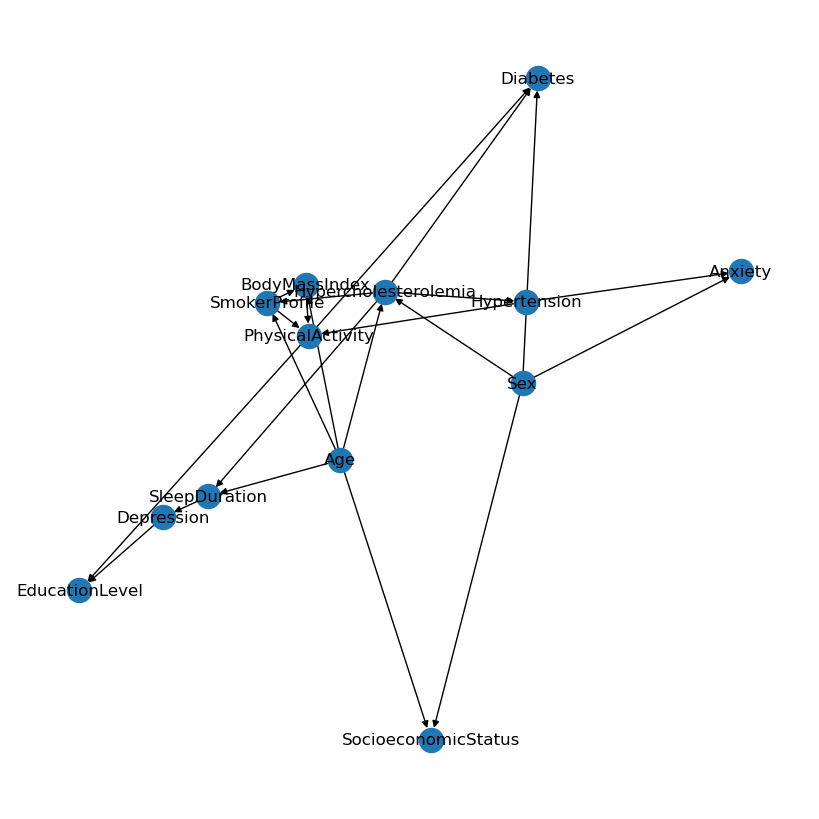

In [11]:
plt.figure(figsize=(8, 8))
nx.draw(nx.DiGraph(best_model.edges()), with_labels=True)
plt.draw()
print(best_model.edges())

## With SMOTE

In [12]:
df_resampled = X_train_resampled
df_resampled['Diabetes'] = y_resampled

In [13]:
df_resampled.head()

,Age,Anxiety,BodyMassIndex,Depression,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus,Diabetes
0,4,0,2,0,1,0,0,1,1,0,2,3,0
1,1,0,1,0,2,1,0,1,0,0,1,3,0
2,1,0,2,0,1,0,0,0,1,0,1,1,0
3,2,0,2,0,1,1,1,1,1,1,1,3,0
4,3,0,2,0,1,0,1,1,0,0,2,3,1


In [14]:
score_metric = BDeuScore(df_resampled)
es = HillClimbSearch(df_resampled)

In [15]:
best_eval_balanced = 0
for x, y in zip(range(0,15), rand_list):
    current_balanced_model = es.estimate(scoring_method=score_metric, black_list=blacklist, start_dag=initialize_graph(nodes=list(nodes), p=y, blacklist=blacklist))
    curr_balanced_eval = score_metric.score(current_balanced_model)
    print(curr_balanced_eval)
    if curr_balanced_eval < best_eval_balanced:
        best_eval_balanced = curr_balanced_eval
        best_balanced_model = current_balanced_model

print(best_eval_balanced)

  0%|          | 0/1000000 [00:00<?, ?it/s]

-40237.78229577239


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40323.51641560772


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40292.05329713743


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40372.55791069651


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40350.7424061256


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40273.95401493411


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40384.57971588798


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40365.7618705292


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40211.147695346335


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40193.14329394883


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40319.90210470327


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40509.056784247136


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40191.455353312514


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40267.861134322164


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40414.48247586103
-40509.056784247136


[('Sex', 'Diabetes'), ('Sex', 'PhysicalActivity'), ('Sex', 'Anxiety'), ('Hypertension', 'BodyMassIndex'), ('Hypertension', 'Anxiety'), ('SleepDuration', 'EducationLevel'), ('Age', 'Hypercholesterolemia'), ('Age', 'PhysicalActivity'), ('Age', 'Diabetes'), ('Hypercholesterolemia', 'Hypertension'), ('Depression', 'SleepDuration'), ('Depression', 'EducationLevel'), ('BodyMassIndex', 'SocioeconomicStatus'), ('BodyMassIndex', 'SmokerProfile'), ('Diabetes', 'PhysicalActivity'), ('Diabetes', 'EducationLevel'), ('Diabetes', 'Anxiety'), ('Diabetes', 'BodyMassIndex'), ('Diabetes', 'SmokerProfile'), ('Diabetes', 'Hypertension'), ('Diabetes', 'SleepDuration'), ('Diabetes', 'Depression'), ('Diabetes', 'Hypercholesterolemia'), ('PhysicalActivity', 'BodyMassIndex'), ('PhysicalActivity', 'Hypertension'), ('PhysicalActivity', 'SmokerProfile'), ('Anxiety', 'SleepDuration'), ('Anxiety', 'Depression'), ('EducationLevel', 'SocioeconomicStatus')]


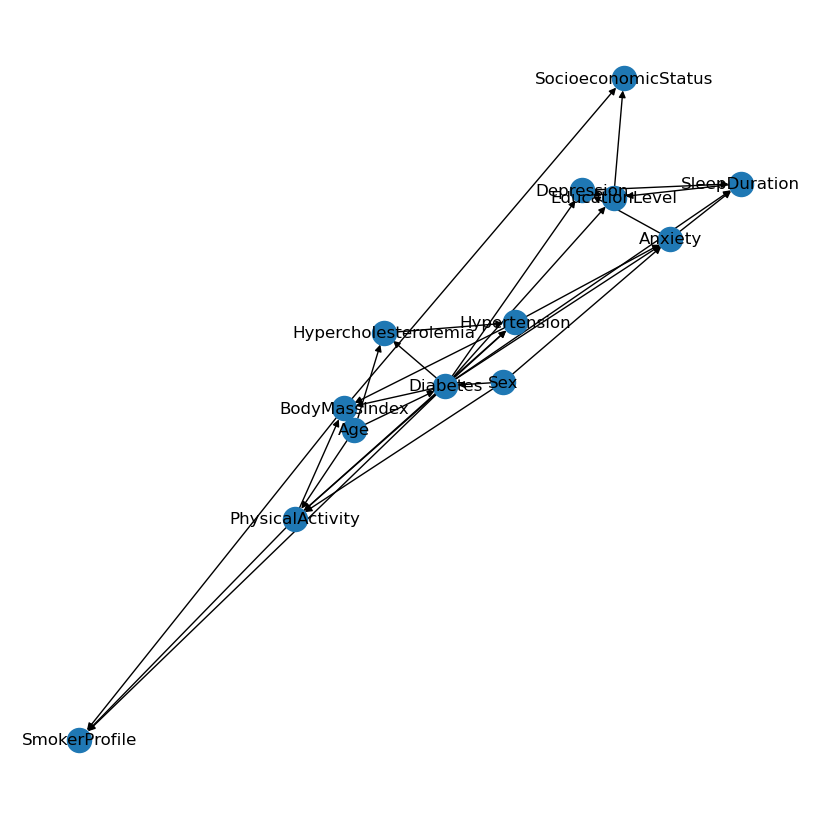

In [16]:
plt.figure(figsize=(8, 8))
nx.draw(nx.DiGraph(best_balanced_model.edges()), with_labels=True)
plt.draw()
print(best_balanced_model.edges())

# Paramether Learning - Using the DAG to get the BPDs

### No SMOTE

In [17]:
bm = BayesianNetwork()
bm.add_nodes_from(nodes)
bm.add_edges_from(best_model.edges)

In [18]:
for col in categorical_columns:
    df_train[col] = encoders[col].inverse_transform(df_train[col])

bm.fit(df_train, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=1)

In [19]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

for c in bm.get_cpds():
    print_full(c)


+-------------+---------+
| Sex(Female) | 0.31921 |
+-------------+---------+
| Sex(Male)   | 0.68079 |
+-------------+---------+
+----------------------+--------------------------+---------------------------+
| Hypercholesterolemia | Hypercholesterolemia(No) | Hypercholesterolemia(Yes) |
+----------------------+--------------------------+---------------------------+
| Hypertension(No)     | 0.8839779005524862       | 0.6878342245989305        |
+----------------------+--------------------------+---------------------------+
| Hypertension(Yes)    | 0.11602209944751381      | 0.31216577540106955       |
+----------------------+--------------------------+---------------------------+
+-------------------------+--------------------------+---------------------------+--------------------------+---------------------------+--------------------------+---------------------------+--------------------------+---------------------------+--------------------------+---------------------------+--------

In [20]:
infer = VariableElimination(bm)

for Age in df_train['Age'].unique(): # sem relacao, justificar. # Pesquisa Cotas a dormir
    print(Age)
    print(infer.query(['SleepDuration'], evidence={'Age': Age}))

54-64
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.8300 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.1667 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0033 |
+-------------------------+----------------------+
24-34
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.9366 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.0589 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0045 |
+-------------------------+----------------------+
34-44
+-------------------------+----------------------+
| SleepDurati

In [21]:
for Profile in df_train['SmokerProfile'].unique():
    print(Profile, 'Diabetes')
    print(infer.query(['Diabetes'], evidence={'SmokerProfile': Profile}))

for Profile in df_train['SmokerProfile'].unique():
    print(Profile, 'Hypercholesterolemia')
    print(infer.query(['Hypercholesterolemia'], evidence={'SmokerProfile': Profile}))

for Profile in df_train['SmokerProfile'].unique():
    print(Profile, 'Hypertension')
    print(infer.query(['Hypertension'], evidence={'SmokerProfile': Profile}))

Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9496 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0504 |
+---------------+-----------------+
Non_Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9531 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0469 |
+---------------+-----------------+
Ex_Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9546 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0454 |
+---------------+-----------------+
Smoker Hypercholesterolemia
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+============

In [22]:
# Dar ganda lengalenga

for Profile in df_train['BodyMassIndex'].unique():
    print(Profile, 'Diabetes')
    print(infer.query(['Diabetes'], evidence={'BodyMassIndex': Profile}))

for Profile in df_train['BodyMassIndex'].unique():
    print(Profile, 'Hypercholesterolemia')
    print(infer.query(['Hypercholesterolemia'], evidence={'BodyMassIndex': Profile}))

for Profile in df_train['BodyMassIndex'].unique():
    print(Profile, 'Hypertension Sex')
    print(infer.query(['Hypertension'], evidence={'BodyMassIndex': Profile}))

Overweight Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9523 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0477 |
+---------------+-----------------+
Obese Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9532 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0468 |
+---------------+-----------------+
Normal Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9517 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0483 |
+---------------+-----------------+
Underweight Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9553 |
+---------------+-----------

In [23]:
for Level in df_train['EducationLevel'].unique():
    for status in df_train['SocioeconomicStatus'].unique():
        print(Level, status)
        print(infer.query(['Depression'], evidence={'EducationLevel': Level, 'SocioeconomicStatus': status}))

print("starts")
for Level in df_train['SocioeconomicStatus'].unique():
    print(Level)
    print(infer.query(['Depression'], evidence={'EducationLevel': Level, 'SocioeconomicStatus': status}))

2 3
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9936 |
+-----------------+-------------------+
| Depression(Yes) |            0.0064 |
+-----------------+-------------------+
2 1
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9937 |
+-----------------+-------------------+
| Depression(Yes) |            0.0063 |
+-----------------+-------------------+
2 2
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9936 |
+-----------------+-------------------+
| Depression(Yes) |            0.0064 |
+-----------------+-------------------+
3 3
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |     

### With SMOTE

In [32]:
bm_resampled = BayesianNetwork()
bm_resampled.add_nodes_from(nodes)
bm_resampled.add_edges_from(best_model.edges)

In [33]:
bm_resampled.fit(df_resampled, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=1)

In [34]:
infer = VariableElimination(bm_resampled) # We can not easily decode the data...

for Age in df_resampled['Age'].unique(): 
    print(infer.query(['SleepDuration'], evidence={'Age': Age}))

+------------------+----------------------+
| SleepDuration    |   phi(SleepDuration) |
+==================+======================+
| SleepDuration(0) |               0.7496 |
+------------------+----------------------+
| SleepDuration(1) |               0.2039 |
+------------------+----------------------+
| SleepDuration(2) |               0.0464 |
+------------------+----------------------+
+------------------+----------------------+
| SleepDuration    |   phi(SleepDuration) |
+==================+======================+
| SleepDuration(0) |               0.8639 |
+------------------+----------------------+
| SleepDuration(1) |               0.0943 |
+------------------+----------------------+
| SleepDuration(2) |               0.0418 |
+------------------+----------------------+
+------------------+----------------------+
| SleepDuration    |   phi(SleepDuration) |
+==================+======================+
| SleepDuration(0) |               0.8718 |
+------------------+------------

Inference with smote isn't working due to an issue with the way we are encoding our values.

# Evaluating The Network

## No Smote

In [35]:
for col in categorical_columns:
    df_test[col] = encoders[col].inverse_transform(df_test[col])

In [36]:
X_test_diabetes = df_test.drop(columns='Diabetes')
y_test_diabetes = df_test['Diabetes']

X_train_diabetes = df_train.drop(columns='Diabetes')
y_train_diabetes = df_test['Diabetes']

y_pred = bm.predict(X_test_diabetes)

print(classification_report(y_test_diabetes, y_pred, zero_division=False))
print(confusion_matrix(y_test_diabetes, y_pred))

  0%|          | 0/808 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.95      1.00      0.98      1224
         Yes       0.00      0.00      0.00        58

    accuracy                           0.95      1282
   macro avg       0.48      0.50      0.49      1282
weighted avg       0.91      0.95      0.93      1282

[[1224    0]
 [  58    0]]


In [37]:
X_test_hypertension = df_test.drop(columns='Hypertension')
y_test_hypertension = df_test['Hypertension']
y_pred = bm.predict(X_test_hypertension)

print(classification_report(y_test_hypertension, y_pred))
print(confusion_matrix(y_test_hypertension, y_pred))


  0%|          | 0/741 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.84      0.98      0.90      1052
         Yes       0.53      0.12      0.20       230

    accuracy                           0.82      1282
   macro avg       0.68      0.55      0.55      1282
weighted avg       0.78      0.82      0.77      1282

[[1027   25]
 [ 202   28]]


In [38]:
X_test_cholesterolemia = df_test.drop(columns='Hypercholesterolemia')
y_test_cholesterolemia = df_test['Hypercholesterolemia']
y_pred = bm.predict(X_test_cholesterolemia)
print(classification_report(y_test_cholesterolemia, y_pred))
print(confusion_matrix(y_test_cholesterolemia, y_pred))

  0%|          | 0/704 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.70      0.90      0.79       795
         Yes       0.68      0.37      0.48       487

    accuracy                           0.70      1282
   macro avg       0.69      0.63      0.63      1282
weighted avg       0.69      0.70      0.67      1282

[[712  83]
 [307 180]]


## With SMOTE

In [39]:
for col in categorical_columns:
    df_test[col] = encoders[col].transform(df_test[col])

In [40]:
X_test_diabetes = df_test.drop(columns='Diabetes')
y_test_diabetes = df_test['Diabetes']

In [41]:
X_resampled_diabetes = df_resampled.drop(columns='Diabetes')
y_test_diabetes = df_test['Diabetes']

y_pred = bm_resampled.predict(X_test_diabetes)

print(classification_report(y_test_diabetes, y_pred, zero_division=False))
print(confusion_matrix(y_test_diabetes, y_pred))

  0%|          | 0/808 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1224
           1       0.00      0.00      0.00        58

    accuracy                           0.95      1282
   macro avg       0.48      0.50      0.49      1282
weighted avg       0.91      0.95      0.93      1282

[[1224    0]
 [  58    0]]


In [42]:
X_test_hypertension = df_test.drop(columns='Hypertension')
y_test_hypertension = df_test['Hypertension']
y_pred = bm_resampled.predict(X_test_hypertension)

print(classification_report(y_test_hypertension, y_pred))
print(confusion_matrix(y_test_hypertension, y_pred))

  0%|          | 0/741 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1052
           1       0.53      0.14      0.23       230

    accuracy                           0.82      1282
   macro avg       0.69      0.56      0.56      1282
weighted avg       0.78      0.82      0.78      1282

[[1023   29]
 [ 197   33]]


In [43]:
X_test_cholesterolemia = df_test.drop(columns='Hypercholesterolemia')
y_test_cholesterolemia = df_test['Hypercholesterolemia']
y_pred = bm_resampled.predict(X_test_cholesterolemia)
print(classification_report(y_test_cholesterolemia, y_pred))
print(confusion_matrix(y_test_cholesterolemia, y_pred))

  0%|          | 0/704 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.68      0.95      0.79       795
           1       0.75      0.26      0.39       487

    accuracy                           0.69      1282
   macro avg       0.71      0.60      0.59      1282
weighted avg       0.71      0.69      0.64      1282

[[753  42]
 [360 127]]
